# An example showing how to generate bootstrapped error bars.

In [1]:
from __future__ import print_function

In [2]:
import os
import sys
import time
import json

import pygsti
from pygsti.construction import std1Q_XYI

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
#Get a GST estimate (similar to Tutorial 0)

# 1) get the target GateSet
gs_target = std1Q_XYI.gs_target

# 2) get the building blocks needed to specify which gate sequences are needed
prep_fiducials, meas_fiducials = std1Q_XYI.prepStrs, std1Q_XYI.effectStrs
germs = std1Q_XYI.germs
maxLengths = [1,2,4,8,16]

# 3) generate "fake" data from a depolarized version of gs_target
gs_datagen = gs_target.depolarize(gate_noise=0.1, spam_noise=0.001)
listOfExperiments = pygsti.construction.make_lsgst_experiment_list(
    gs_target, prep_fiducials, meas_fiducials, germs, maxLengths)
ds = pygsti.construction.generate_fake_data(gs_datagen, listOfExperiments, nSamples=1000,
                                            sampleError="binomial", seed=1234)


results = pygsti.do_stdpractice_gst(ds, gs_target, prep_fiducials, meas_fiducials,
                                    germs, maxLengths, modes="TP")
estimated_gateset = results.estimates['TP'].gatesets['Spam 0.1']

-- Std Practice:  Iter 1 of 1  (TP) --: 
  --- Gate Sequence Creation ---
   1201 sequences created
   Dataset has 1201 entries: 1201 utilized, 0 requested sequences were missing
  --- LGST ---
  --- Iterative MLGST: [##################################################] 100.0%  1201 gate strings ---
  Iterative MLGST Total Time: 1.6s
  -- Performing 'Spam 0.0001' gauge optimization on TP estimate --
  -- Done gauge optimizing (0.0307078s) -- 
  -- Performing 'Spam 0.1' gauge optimization on TP estimate --
  -- Done gauge optimizing (0.0363529s) -- 


## Parametric Bootstrapping
Here we do parametric bootstrapping, as indicated by the 'parametric' argument below.
The output is eventually stored in the "mean" and "std" GateSets, which hold the mean and standard deviation values of the set of bootstrapped gatesets (after gauge optimization).  It is this latter "standard deviation Gateset"
which holds the collection of error bars.  Note: due to print setting issues, the outputs that are printed here will not necessarily reflect the true accuracy of the estimates made.


In [5]:
#The number of simulated datasets & gatesets made for bootstrapping purposes.  
# For good statistics, should probably be greater than 10.
numGatesets=10

param_boot_gatesets = pygsti.drivers.make_bootstrap_gatesets(
                        numGatesets, ds, 'parametric', prep_fiducials, meas_fiducials, germs, maxLengths,
                        inputGateSet=estimated_gateset, startSeed=0, returnData=False,
                        verbosity=2)

Creating DataSets: 
0 Generating parametric dataset.
1 Generating parametric dataset.
2 Generating parametric dataset.
3 Generating parametric dataset.
4 Generating parametric dataset.
5 Generating parametric dataset.
6 Generating parametric dataset.
7 Generating parametric dataset.
8 Generating parametric dataset.
9 Generating parametric dataset.
Creating GateSets: 
Running MLGST Iteration 0 
--- Gate Sequence Creation ---
 1201 sequences created
 Dataset has 1201 entries: 1201 utilized, 0 requested sequences were missing
--- LGST ---
  Singular values of I_tilde (truncating to first 4 of 6) = 
  4.24419689375
  1.19036956184
  0.967464884093
  0.922608773941
  0.0480808376381
  0.0173785707535
  
  Singular values of target I_tilde (truncating to first 4 of 6) = 
  4.24421897248
  1.1665506003
  0.949248248555
  0.938688079729
  2.75344634043e-16
  1.59044385871e-16
  
--- Iterative MLGST: Iter 1 of 5  92 gate strings ---: 
  --- Minimum Chi^2 GST ---
  Created evaluation tree with 1

In [6]:
gauge_opt_pboot_gatesets = pygsti.drivers.gauge_optimize_gs_list(param_boot_gatesets, estimated_gateset,
                                                                 plot=False) #plotting support removed w/matplotlib

Spam weight 0
Spam weight 1
Spam weight 2
Spam weight 3
Spam weight 4
Spam weight 5
Spam weight 6
Spam weight 7
Spam weight 8
Spam weight 9
Spam weight 10
Spam weight 11
Spam weight 12
Best SPAM weight is 1.0


In [7]:
pboot_mean = pygsti.drivers.to_mean_gateset(gauge_opt_pboot_gatesets, estimated_gateset)
pboot_std  = pygsti.drivers.to_std_gateset(gauge_opt_pboot_gatesets, estimated_gateset)

#Summary of the error bars
print("Parametric bootstrapped error bars, with", numGatesets, "resamples\n")
print("Error in rho vec:") 
print(pboot_std['rho0'], end='\n\n')
print("Error in E vec:")
print(pboot_std['E0'], end='\n\n')
print("Error in Gi:")
print(pboot_std['Gi'], end='\n\n')
print("Error in Gx:")
print(pboot_std['Gx'], end='\n\n')
print("Error in Gy:")
print(pboot_std['Gy'])

Parametric bootstrapped error bars, with 10 resamples

Error in rho vec:
TP-Parameterized spam vector with length 4
 0.71
   0
   0
   0


Error in E vec:
Fully Parameterized spam vector with length 4
   0
   0
   0
   0


Error in Gi:
TP Parameterized gate with shape (4, 4)
 1.00   0   0   0
   0   0   0   0
   0   0   0   0
   0   0   0   0


Error in Gx:
TP Parameterized gate with shape (4, 4)
 1.00   0   0   0
   0   0   0   0
   0   0   0   0
   0   0   0   0


Error in Gy:
TP Parameterized gate with shape (4, 4)
 1.00   0   0   0
   0   0   0   0
   0   0   0   0
   0   0   0   0



## Non-parametric Bootstrapping
Here we do non-parametric bootstrapping, as indicated by the 'nonparametric' argument below.
The output is again eventually stored in the "mean" and "std" GateSets, which hold the mean and standard deviation values of the set of bootstrapped gatesets (after gauge optimization).  It is this latter "standard deviation Gateset"
which holds the collection of error bars.  Note: due to print setting issues, the outputs that are printed here will not necessarily reflect the true accuracy of the estimates made.

(Technical note: ddof = 1 is by default used when computing the standard deviation -- see numpy.std -- meaning that we are computing a standard deviation of the sample, not of the population.)

In [8]:
#The number of simulated datasets & gatesets made for bootstrapping purposes.  
# For good statistics, should probably be greater than 10.
numGatesets=10

nonparam_boot_gatesets = pygsti.drivers.make_bootstrap_gatesets(
                          numGatesets, ds, 'nonparametric', prep_fiducials, meas_fiducials, germs, maxLengths,
                          targetGateSet=estimated_gateset, startSeed=0, returnData=False, verbosity=2)

Creating DataSets: 
0 Generating non-parametric dataset.
1 Generating non-parametric dataset.
2 Generating non-parametric dataset.
3 Generating non-parametric dataset.
4 Generating non-parametric dataset.
5 Generating non-parametric dataset.
6 Generating non-parametric dataset.
7 Generating non-parametric dataset.
8 Generating non-parametric dataset.
9 Generating non-parametric dataset.
Creating GateSets: 
Running MLGST Iteration 0 
--- Gate Sequence Creation ---
 1201 sequences created
 Dataset has 1201 entries: 1201 utilized, 0 requested sequences were missing
--- LGST ---
  Singular values of I_tilde (truncating to first 4 of 6) = 
  4.24503048865
  1.18028761802
  0.988503065855
  0.897667246319
  0.112759441348
  0.0209714393494
  
  Singular values of target I_tilde (truncating to first 4 of 6) = 
  4.24421897248
  1.1665506003
  0.949248248555
  0.938688079729
  2.75344634043e-16
  1.59044385871e-16
  
--- Iterative MLGST: Iter 1 of 5  92 gate strings ---: 
  --- Minimum Chi^2 G

In [9]:
gauge_opt_npboot_gatesets = pygsti.drivers.gauge_optimize_gs_list(nonparam_boot_gatesets, estimated_gateset,
                                                                 plot=False) #plotting removed w/matplotlib

Spam weight 0
Spam weight 1
Spam weight 2
Spam weight 3
Spam weight 4
Spam weight 5
Spam weight 6
Spam weight 7
Spam weight 8
Spam weight 9
Spam weight 10
Spam weight 11
Spam weight 12
Best SPAM weight is 1.0


In [10]:
npboot_mean = pygsti.drivers.to_mean_gateset(gauge_opt_npboot_gatesets, estimated_gateset)
npboot_std  = pygsti.drivers.to_std_gateset(gauge_opt_npboot_gatesets, estimated_gateset)

#Summary of the error bars
print("Non-parametric bootstrapped error bars, with", numGatesets, "resamples\n")
print("Error in rho vec:")
print(npboot_std['rho0'], end='\n\n')
print("Error in E vec:")
print(npboot_std['E0'], end='\n\n')
print("Error in Gi:")
print(npboot_std['Gi'], end='\n\n')
print("Error in Gx:")
print(npboot_std['Gx'], end='\n\n')
print("Error in Gy:")
print(npboot_std['Gy'])

Non-parametric bootstrapped error bars, with 10 resamples

Error in rho vec:
TP-Parameterized spam vector with length 4
 0.71
   0
   0
   0


Error in E vec:
Fully Parameterized spam vector with length 4
   0
   0
   0
   0


Error in Gi:
TP Parameterized gate with shape (4, 4)
 1.00   0   0   0
   0   0   0   0
   0   0   0   0
   0   0   0   0


Error in Gx:
TP Parameterized gate with shape (4, 4)
 1.00   0   0   0
   0   0   0   0
   0   0   0   0
   0   0   0   0


Error in Gy:
TP Parameterized gate with shape (4, 4)
 1.00   0   0   0
   0   0   0   0
   0   0   0   0
   0   0   0   0



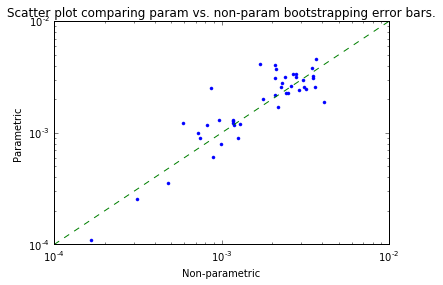

In [11]:
loglog(npboot_std.to_vector(),pboot_std.to_vector(),'.')
loglog(np.logspace(-4,-2,10),np.logspace(-4,-2,10),'--')
xlabel('Non-parametric')
ylabel('Parametric')
xlim((1e-4,1e-2)); ylim((1e-4,1e-2))
title('Scatter plot comparing param vs. non-param bootstrapping error bars.')